Every salesman has a max load that can not be exceeded and the load has to be delivered to the destination. Every salesman can have multiple routes. The cost for one salesman is set to 0, every other salesman has a higher cost, yielding to avoid using them.

There is one start location, one delivery point, and one final destination, which is the start location (e.g., garbage collecting company). 

Certain locations have a higher priority, i.e., they must be in the solution.


In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import copy
import itertools


### Initialize the problem

In [2]:
numPoints = 60

# Generate random locations
X = []
Y = []

for i in range(numPoints):
    X.append(random.uniform(0,100))
    Y.append(random.uniform(0,100))
    

In [3]:
# Locations in a dataframe
df = pd.DataFrame()
df['ID'] = list(np.arange(1,numPoints+1))
df['X'] = X
df['Y'] = Y

# Put locations in a list
locations = list(df['ID'])


In [4]:
# Distance matrix
distance_matrix = []

for i in range(df.shape[0]):
    row = []
    
    for j in range(df.shape[0]):
        distance = np.sqrt((df['X'].iloc[i] - df['X'].iloc[j])**2 + (df['Y'].iloc[i] - df['Y'].iloc[j])**2)
        row.append(distance)
        
    distance_matrix.append(row)
    
# Make a copy of the distance matrix for manipulations
distance_matrix_copy = copy.deepcopy(distance_matrix)
distance_matrix_plot = copy.deepcopy(distance_matrix)
    

In [5]:
# Color dictionary to plot the solution
numbers = []
colors = []

for i in range(len(list(mcolors.CSS4_COLORS))):
    numbers.append(i)
 
# for bigger problems
colors = list(mcolors.CSS4_COLORS)
# for smaller problems
#colors = list(mcolors.BASE_COLORS)

# Convert lists to dictionary
color_dict = {}
for key in numbers:
    for value in colors:
        color_dict[key] = value
        colors.remove(value)
        break


### Problem Setup

In [6]:
# number of salesmen
SALESMEN = 3
SALESMEN_ROUTES = SALESMEN*3
SALESMEN_COST_HOME = 0 #route from start to delivery
SALESMEN_COST_INTER = 5000 #route from delivery to delivery
SALEMEN_COST_RETURN = 50000 #route from start to start (which is the finish)
SALESMEN_COST_ADDITIONAL = 100000 #cost for a new salesman
MAX_LOAD = 10
MISSING_LOCATION = 1000 #cost for locations that are not being inserted into the solution
DISTANCE_MAX = 1300
 
locations_copy = copy.deepcopy(locations)

# routes for the salesmen
res = []
LOAD = [0] * (SALESMEN_ROUTES+SALESMEN)

# Final route may not contain pickup locations
for i in range(SALESMEN):
    LOAD.append(MAX_LOAD)

# Get a start location
start_location = random.sample(locations_copy, k=1)[0]
locations_copy.remove(start_location)
unused_locations = copy.deepcopy(locations)
unused_locations.remove(start_location)

# Landfill location (delivery)
LANDFILL = random.sample(locations_copy, k=1)[0]
locations_copy.remove(LANDFILL)
unused_locations.remove(LANDFILL)

for i in range(SALESMEN):
    res.append([start_location,LANDFILL])

for i in range(SALESMEN_ROUTES):
    res.append([LANDFILL,LANDFILL])

for i in range(SALESMEN):
    res.append([LANDFILL,start_location])
    
# Total distance
distance = [0] * (SALESMEN_ROUTES+2*SALESMEN)


In [7]:
# Add names to the locations for plots
names = []

for i in range(df.shape[0]):
    if df['ID'].iloc[i] == start_location:
        names.append('Start')
    elif df['ID'].iloc[i] == LANDFILL:
        names.append('Landfill')
    else:
        names.append(i+1)

df['NAME'] = names


In [8]:
# Add priority to the locations (higher priority means locations must be in solution)
priority = []

for i in range(df.shape[0]):
    priority.append(random.sample([1,5], k=1)[0])
    
df['PRIORITY'] = priority
        

In [9]:
for i in range(len(res)):
    for j in range(len(res[i])-1):
        distance[i] += distance_matrix_copy[res[i][j]-1][res[i][j+1]-1]
        
total_distance = [0] * SALESMEN

for i in range(len(res)):
    for j in range(SALESMEN):
        if i % SALESMEN == j:
            total_distance[i%(j+1)] += distance[i]
    

In [10]:
# Create random intial route
for i in range(len(locations_copy)):    
    
    res_interim = copy.deepcopy(res)
    total_distance_interim = [0] * (SALESMEN_ROUTES+2*SALESMEN)

    # In case there are more locations than available total space
    try:
        # Route to insert (a new location can only be inserted if the load is below the max threshold)
        insertion = random.sample(list(np.where(np.array(LOAD) < MAX_LOAD)[0]), k=1)[0]

        # Select a random location to insert
        random_location = random.sample(locations_copy, k=1)[0]
        locations_copy.remove(random_location)

        # Select a random spot to insert
        random_spot = random.sample(range(1,len(res_interim[insertion])),k=1)[0]
        res_interim[insertion].insert(random_spot,random_location)

        for k in range(len(res_interim)):
            for j in range(len(res_interim[k])-1):
                total_distance_interim[k] += distance_matrix_copy[res_interim[k][j]-1][res_interim[k][j+1]-1]

        total_distance_interim_sum = [0] * SALESMEN

        for k in range(len(res)):
            for j in range(SALESMEN):
                if k % SALESMEN == j:
                    total_distance_interim_sum[k%(j+1)] += total_distance_interim[k]
                    
        if all (total_distance_interim) <= DISTANCE_MAX:
            res = res_interim
            total_distance = total_distance_interim
            unused_locations.remove(random_location)
            LOAD[insertion] += 1

    except: ValueError


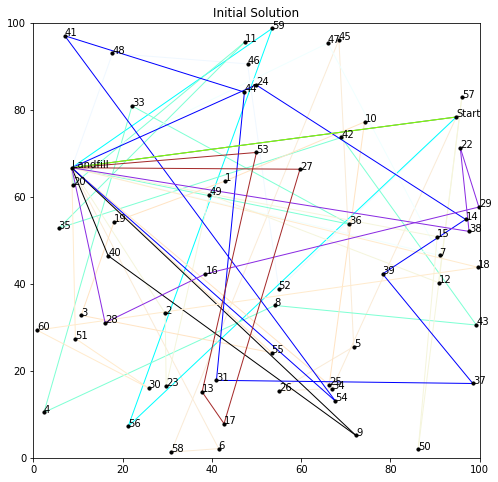

In [11]:
# Initial result
plt.figure(figsize=(8,8))
plt.scatter(df['X'], df['Y'], c='black', zorder=2000, s=10)

for i in range(numPoints):
    plt.annotate(text = df['NAME'].iloc[i], xy = (df['X'].iloc[i], df['Y'].iloc[i]))
    
for k in range(len(res)):
    for i in range(len(res[k])-1):
        plt.plot((df['X'].iloc[res[k][i]-1],df['X'].iloc[res[k][i+1]-1]),
                 (df['Y'].iloc[res[k][i]-1],df['Y'].iloc[res[k][i+1]-1]),
                  c=color_dict[k], linewidth=1)
            
plt.title('Initial Solution')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


### Solving the problem

In [12]:
locations_copy = copy.deepcopy(locations)
locations_copy.remove(start_location)
locations_copy.remove(LANDFILL)


In [13]:
### Branch-and-cut Solution

# Develeopment of the solution
history = []

# shortest route
shortest_route = [0]*(2*SALESMEN+SALESMEN_ROUTES)
shortest_distance = [0]*(2*SALESMEN+SALESMEN_ROUTES)

for i in range(len(res)):
    for j in range(len(res[i])-1):
        shortest_route[i] += distance_matrix_copy[res[i][j]-1][res[i][j+1]-1]
        shortest_distance[i] += distance_matrix_copy[res[i][j]-1][res[i][j+1]-1]
    if len(res[i]) > 2:
        if res[i][0] == start_location:
            shortest_route[i] += SALESMEN_COST_HOME
        elif res[i][-1] == start_location:
            shortest_route[i] += SALEMEN_COST_RETURN
        else:
            shortest_route[i] += SALESMEN_COST_INTER
            
missing_priority = 0

for loc in unused_locations:
    missing_priority += priority[loc-1]
    
# Cost for additional salesman    
COST = []
for i in range(len(res)):
    if i%SALESMEN == 0:
        COST.append(0)
    else:
        # Vevery additional salesman has a higher cost, yielding their avoidance in the final solution
        COST.append(SALESMEN_COST_ADDITIONAL * (10**(i%SALESMEN)))

# Additional cost
cost_add = []

# every location in the route has a cost
for i in range(len(res)):
    cost_add.append((len(res[i])-2)*COST[i])
    
# every newly used route has a cost
for i in range(len(res)):
    if len(res[i]) > 2:
        cost_add[i] += COST[i]
    
# Objective
objective = sum(shortest_route) + MISSING_LOCATION * missing_priority + sum(cost_add)
history.append(objective)

print(res)
print('Lengths of the routes:', shortest_distance)
print('Objective initial solution:', objective)


[[21, 52, 46, 48, 32], [21, 34, 26, 5, 45, 58, 6, 32], [21, 56, 59, 32], [32, 36, 33, 4, 8, 43, 42, 35, 11, 20, 32], [32, 7, 47, 32], [32, 15, 50, 57, 12, 49, 23, 2, 32], [32, 55, 3, 19, 1, 10, 25, 32], [32, 40, 9, 32], [32, 51, 30, 60, 18, 32], [32, 54, 41, 44, 31, 37, 39, 14, 24, 32], [32, 28, 16, 29, 22, 38, 32], [32, 53, 13, 17, 27, 32], [32, 21], [32, 21], [32, 21]]
Lengths of the routes: [166.37526102233318, 355.802090885466, 254.4724658093143, 528.6666730952481, 203.87945896806542, 413.2633306845129, 325.8307752997551, 179.60464437933157, 281.2873450448983, 506.113383872241, 248.53448538260488, 218.76428849572676, 86.95119119069265, 86.95119119069265, 86.95119119069265]
Objective initial solution: 229048943.44777653


In [14]:
# Initial solution
print(res)
print('Lengths of the routes:', shortest_distance)
print('Current best solution:', objective)
print()

for tries in range(10000):    
    # maximum number of locations to remove
    max_removes = int(np.round(len(locations)/2))

    # make a copy of the current route
    res_interim = copy.deepcopy(res)    
    LOAD_interim = copy.deepcopy(LOAD)

    # locations to remove (at least 1)
    number = random.sample(range(1,max_removes), 1)[0]
    loc_remove = random.sample(locations_copy, number)

    # remove locations and loads from route
    for loc in (loc_remove):   
        for i in range(len(res_interim)):
            if loc in res_interim[i]:
                res_interim[i].remove(loc)
                LOAD_interim[i] -= 1

    try:

        # randomly insert locations into result
        for loc in (loc_remove):
            # Route to insert
            insertion = random.sample(list(np.where(np.array(LOAD_interim) < MAX_LOAD)[0]), k=1)[0]
            LOAD_interim[insertion] += 1

            insert_position = np.random.randint(1,len(res_interim[insertion]))
            res_interim[insertion].insert(insert_position, loc)

    except: ValueError

    current_route_interim = [0]*(2*SALESMEN+SALESMEN_ROUTES)
    current_distance_interim = [0]*(2*SALESMEN+SALESMEN_ROUTES)

    for i in range(len(res_interim)):
        for j in range(len(res_interim[i])-1):
            current_route_interim[i] += distance_matrix_copy[res_interim[i][j]-1][res_interim[i][j+1]-1]
            current_distance_interim[i] += distance_matrix_copy[res_interim[i][j]-1][res_interim[i][j+1]-1]
        if len(res_interim[i]) > 2:
            if res_interim[i][0] == start_location:
                current_route_interim[i] += SALESMEN_COST_HOME
            elif res_interim[i][-1] == start_location:
                current_route_interim[i] += SALEMEN_COST_RETURN
            else:
                current_route_interim[i] += SALESMEN_COST_INTER
                
    # Additional cost for a used route of an additional salesman
    cost_add = []

    for i in range(len(res_interim)):
        cost_add.append((len(res_interim[i])-2)*COST[i])
        
    # every newly used route has a cost
    for i in range(len(res_interim)):
        if len(res_interim[i]) > 2:
            cost_add[i] += COST[i]

    current_objective = sum(current_route_interim) + sum(cost_add)

    total_distance_interim_su_interimm = [0] * SALESMEN

    for k in range(len(res_interim)):
        for j in range(SALESMEN):
            if k % SALESMEN == j:
                total_distance_interim_sum[k%(j+1)] += current_distance_interim[k]

     # Locations that are not part of the solution
    used_locations = []

    for i in range(len(res_interim)):
        for k in range(len(locations)):
            if locations[k] in res_interim[i]:
                used_locations.append(locations[k])

    unused_locations = [x for x in locations if x not in used_locations]

    # Sum of missing priorities
    missing_priority = 0
    for loc in unused_locations:
        missing_priority += priority[loc-1]

    if current_objective + MISSING_LOCATION * missing_priority < objective and all (total_distance_interim_sum) <= DISTANCE_MAX:
        objective = current_objective + MISSING_LOCATION * missing_priority
        res = res_interim
        LOAD = LOAD_interim

    history.append(objective)

print(res)

# Objective
shortest_route = [0]*(2*SALESMEN+SALESMEN_ROUTES)
shortest_distance = [0]*(2*SALESMEN+SALESMEN_ROUTES)

for i in range(len(res)):
    for j in range(len(res[i])-1):
        shortest_route[i] += distance_matrix_copy[res[i][j]-1][res[i][j+1]-1]
        shortest_distance[i] += distance_matrix_copy[res[i][j]-1][res[i][j+1]-1]
    if len(res[i]) > 2:
        if res[i][0] == start_location:
            shortest_route[i] += SALESMEN_COST_HOME
        elif res[i][-1] == start_location:
            shortest_route[i] += SALEMEN_COST_RETURN
        else:
            shortest_route[i] += SALESMEN_COST_INTER
        
print('Lengths of the routes:', shortest_distance)
print('Objective:', objective)


[[21, 52, 46, 48, 32], [21, 34, 26, 5, 45, 58, 6, 32], [21, 56, 59, 32], [32, 36, 33, 4, 8, 43, 42, 35, 11, 20, 32], [32, 7, 47, 32], [32, 15, 50, 57, 12, 49, 23, 2, 32], [32, 55, 3, 19, 1, 10, 25, 32], [32, 40, 9, 32], [32, 51, 30, 60, 18, 32], [32, 54, 41, 44, 31, 37, 39, 14, 24, 32], [32, 28, 16, 29, 22, 38, 32], [32, 53, 13, 17, 27, 32], [32, 21], [32, 21], [32, 21]]
Lengths of the routes: [166.37526102233318, 355.802090885466, 254.4724658093143, 528.6666730952481, 203.87945896806542, 413.2633306845129, 325.8307752997551, 179.60464437933157, 281.2873450448983, 506.113383872241, 248.53448538260488, 218.76428849572676, 86.95119119069265, 86.95119119069265, 86.95119119069265]
Current best solution: 229048943.44777653

[[21, 29, 22, 26, 6, 34, 23, 58, 14, 1, 27, 32], [21, 42, 51, 32], [21, 32], [32, 33, 8, 19, 35, 55, 36, 43, 7, 46, 45, 32], [32, 4, 30, 56, 57, 47, 32], [32, 32], [32, 16, 25, 12, 37, 53, 60, 52, 20, 3, 10, 32], [32, 40, 28, 50, 9, 18, 32], [32, 32], [32, 48, 59, 24, 39

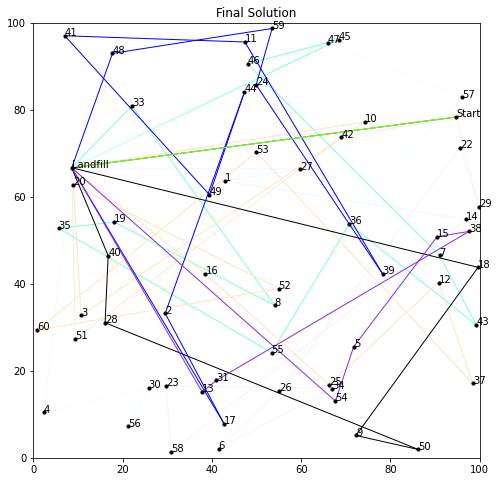

In [15]:
# Final result
plt.figure(figsize=(8,8))
plt.scatter(df['X'], df['Y'], c='black', zorder=2000, s=10)

for i in range(numPoints):
    plt.annotate(text = df['NAME'].iloc[i], xy = (df['X'].iloc[i], df['Y'].iloc[i]))

for k in range(len(res)):
    for i in range(len(res[k])-1):
        plt.plot((df['X'].iloc[res[k][i]-1],df['X'].iloc[res[k][i+1]-1]),
                 (df['Y'].iloc[res[k][i]-1],df['Y'].iloc[res[k][i+1]-1]),
                  c=color_dict[k], linewidth=1)
            
plt.title('Final Solution')
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()


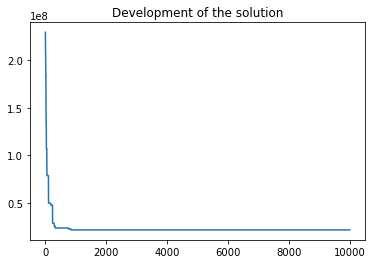

In [16]:
plt.plot(history)
plt.title('Development of the solution')
plt.show()
